In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

100% 3.74G/3.75G [00:55<00:00, 65.4MB/s]
100% 3.75G/3.75G [00:55<00:00, 72.4MB/s]


In [4]:
!unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [6]:
path = '/content/real_vs_fake/real-vs-fake'
size = (256, 256)


datagen = ImageDataGenerator(rescale=1./255.,
                              horizontal_flip=True)

train = datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 target_size=size,
                                                 batch_size=64
                                                )

Found 100000 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
val = test_datagen.flow_from_directory(path + '/valid',
                                  target_size=size,
                                  batch_size=64,
                                  class_mode='binary')
test = test_datagen.flow_from_directory(path + '/test',
                                    target_size=size,
                                    batch_size=64,
                                    class_mode='binary',
                                    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [8]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.applications import DenseNet121
from keras.models import Sequential


densenet = DenseNet121(weights=None,
                           include_top=False,
                           input_shape=(256, 256, 3)
                          )

model = Sequential()

model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='model.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3)


history = model.fit(train,
                    validation_data=val,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    epochs=20
                   )

Epoch 1/20
1563/1563 [==============================] - 454s 290ms/step - loss: 0.0938 - accuracy: 0.9646 - val_loss: 0.3414 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 453s 290ms/step - loss: 0.0763 - accuracy: 0.9706 - val_loss: 0.1967 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 454s 290ms/step - loss: 0.0644 - accuracy: 0.9760 - val_loss: 0.5918 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 452s 289ms/step - loss: 0.0536 - accuracy: 0.9798 - val_loss: 0.1268 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 453s 290ms/step - loss: 0.0463 - accuracy: 0.9828 - val_loss: 0.1270 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 454s 290ms/step - loss: 0.0402 - accuracy: 0.9851 - val_loss: 0.0781 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 7/20
1563/1563 [============

In [11]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")

In [12]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

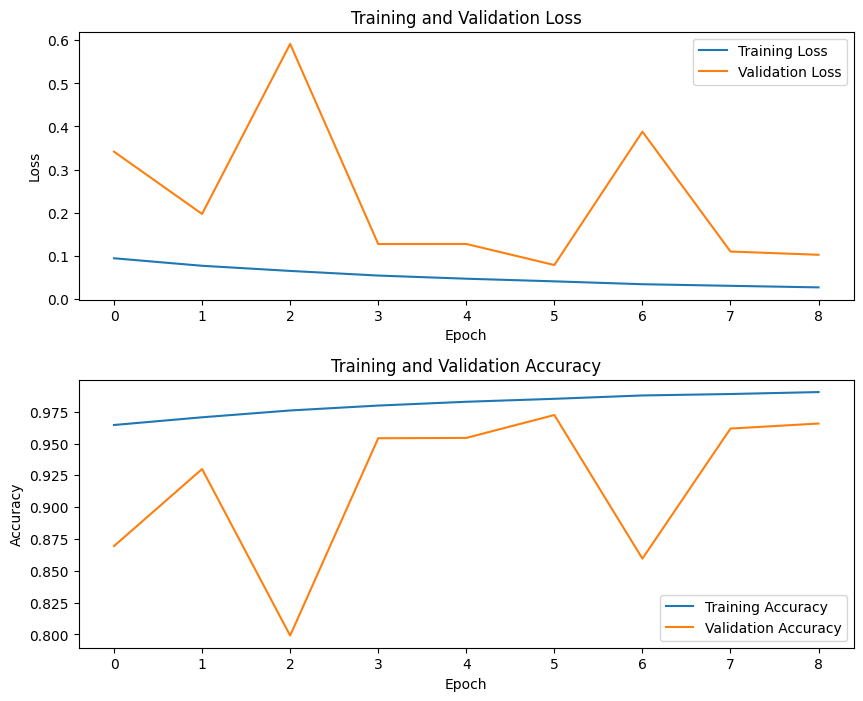

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

loaded_history = pd.read_csv('training_history.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(loaded_history['loss'], label='Training Loss')
ax1.plot(loaded_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.grid(False)

ax2.plot(loaded_history['accuracy'], label='Training Accuracy')
ax2.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.grid(False)
plt.subplots_adjust(hspace=0.3)
plt.savefig('training_metrics_plot.png')

plt.show()


In [14]:
accu = model.evaluate(test)[1]
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 46s 148ms/step - loss: 0.0745 - accuracy: 0.9740
Final Test Acccuracy = 97.395


In [15]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [16]:
y_pred = model.predict(test)

313/313 [==============================] - 48s 146ms/step


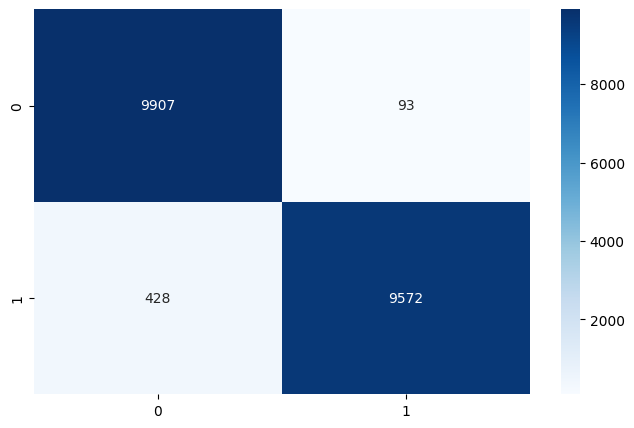

In [17]:
from sklearn import metrics
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(test.classes, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [18]:
print("ROC-AUC Score:", metrics.roc_auc_score(test.classes, y_pred.round()))
print("AP Score:", metrics.average_precision_score(test.classes, y_pred.round()))

ROC-AUC Score: 0.9739500000000001
AP Score: 0.9693894878427315


In [19]:
report = classification_report(test.classes, y_pred.round())
print('\nClassification Report')
print(report)


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10000
           1       0.99      0.96      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

